In [1]:
import json
import pandas as pd
import community
import networkx as nx
import matplotlib.pyplot as plt
import csv

In [2]:
from twitter import *

In [3]:
# Loading my authentication tokens
with open('auth_dict','r') as f:
    twtr_auth = json.load(f)

# To make it more readable, lets store
# the OAuth credentials in strings first.
CONSUMER_KEY = twtr_auth['consumer_key']
CONSUMER_SECRET = twtr_auth['consumer_secret']
OAUTH_TOKEN = twtr_auth['token']
OAUTH_TOKEN_SECRET = twtr_auth['token_secret']
    
# Then, we store the OAuth object in "auth"
auth = OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                           CONSUMER_KEY, CONSUMER_SECRET)
# Notice that there are four tokens - you need to create these in the
# Twitter Apps dashboard after you have created your own "app".

# We now create the twitter search object.
t = Twitter(auth=auth)

In [4]:
import sys
import time
from twitter.api import TwitterHTTPError
from urllib.error import URLError
from http.client import BadStatusLine

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
        if wait_period > 3600: # Seconds
            print('Too many retries. Quitting.', file=sys.stderr)
            raise e
        if e.e.code == 401:
            return None
        elif e.e.code == 404:
            print('Encountered 404 Error (Not Found)', file=sys.stderr)
            return None
        elif e.e.code == 429:
            print('Encountered 429 Error (Rate Limit Exceeded)', file=sys.stderr)
            if sleep_when_rate_limited:
                print("Retrying in 15 minutes...ZzZ...", file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print('...ZzZ...Awake now and trying again.', file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period), file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0
    while True:
        try:
            return twitter_api_func(*args, **kw)
        except TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            print("URLError encountered. Continuing.", file=sys.stderr)
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print("Too many consecutive errors...bailing out.", file=sys.stderr)
                raise

In [5]:
# This will let us create new partial
# functions with arguments set to 
# certain values.
from functools import partial

# This was maxint.
# There is no longer a maxint (in Python 3)
from sys import maxsize


def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                                friends_limit=maxsize, followers_limit=maxsize):
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    # You can also do this with a function closure.
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids,
                                count=100)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids,
                                count=100)
    friends_ids, followers_ids = [], []
    for twitter_api_func, limit, ids, label in [
            [get_friends_ids, friends_limit, friends_ids, "friends"],
            [get_followers_ids, followers_limit, followers_ids, "followers"]
            ]:
        #LOOK HERE! This little line is important.
        if limit == 0: continue
        cursor = -1
        while cursor != 0:
            # Use make_twitter_request via the partially bound callable...
            if screen_name:
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)
            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
            print('Fetched {0} total {1} ids for {2}'.format(len(ids),
                    label, (user_id or screen_name), file=sys.stderr))
            if len(ids) >= limit or response is None:
                break
    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]


In [6]:
# Create a mostly empty data frame,
# and write it to a CSV file.
df = pd.DataFrame(columns=['ID','followers'])
df.to_csv('followers.csv', index=False)

# Our function
def save_followers(fid, followers):
    df = pd.DataFrame([[fid, followers]], columns=['ID','followers'])
    with open('followers.csv', 'a') as f:
        df.to_csv(f,header=False, index=False)

In [6]:
import networkx as nx
import numpy as np
check = set()
limit_100 = set()
def crawl_followers(twitter_api, screen_name, depth=4, limit=100):
    
    # Resolve the ID for screen_name and start working with IDs for consistency
    seed_id = str(twitter_api.users.show(screen_name=screen_name)['id'])
    friends , followers = get_friends_followers_ids(twitter_api, user_id=seed_id,
                        friends_limit=limit, followers_limit=limit)
    
    respro = set(friends) & set(followers)
    seed_id = int(seed_id)
    # Store a seed_id => _follower_ids mapping in MongoDB
    next_queue = Only_five_friends(twitter_api, user_ids=respro)
    save_followers(seed_id, ','.join([str(x) for x in next_queue]))
    limit_100.add(seed_id)
    
    check.add(seed_id)
    for x in next_queue:
        limit_100.add(x)
    d = 1
    # Note that in the example in the next cell,
    # we never enter this loop.
    while d < depth:
        if(len(limit_100) >100):
            return
        d += 1
        # Reset the next_queue so that we can
        # start building up the next level
        # of followers-of-followers
        (queue, next_queue) = (next_queue, [])
        # Loop through the current
        # level of followers
        for fid in queue:
            if(len(limit_100) >100):
                return
            if not(fid in check):
                friends_ids, follower_ids = get_friends_followers_ids(twitter_api, user_id=fid,
                                    friends_limit=limit, followers_limit=limit)
                # Store an ID with a string recording
                # IDs of followers of the user with ID "fid"
                respro2 = set(friends_ids) & set(follower_ids)
                next_queue1 = Only_five_friends(twitter_api, user_ids=respro2)
                save_followers(str(fid), ','.join([str(x) for x in next_queue1]))

                for x in next_queue1:
                    limit_100.add(x)
                check.add(fid)

                # Extending the list
                next_queue += next_queue1

### Only_five_friends() will return Five friends from the list of resiprocal friends

In [7]:
def Only_five_friends(t, user_ids):
    values = []
    result = set()
    if not(len(user_ids) > 0):
        return result
    user_ids_1 = ','.join([str(x) for x in user_ids])
    temp = t.users.lookup(user_id = str(user_ids_1))

    for a in temp:
        values.append(a['followers_count'])
    
    followers_count = dict (zip(user_ids,values))
    temp = sorted(followers_count.items(), key=lambda x: x[1], reverse=True)
    
    count = 0
    for elem in temp:
        if(count >= 5):
            break
        result.add(elem[0])
        count += 1
    return result

In [9]:
screen_name = "SyviiS"
crawl_followers(t, screen_name, depth=4, limit=100)

Fetched 78 total friends ids for 1631758140
Fetched 29 total followers ids for 1631758140
Fetched 100 total friends ids for 796830388610011136
Fetched 100 total followers ids for 796830388610011136
Fetched 100 total friends ids for 130971502
Fetched 100 total followers ids for 130971502
Fetched 100 total friends ids for 474436312
Fetched 100 total followers ids for 474436312
Fetched 100 total friends ids for 252766425
Fetched 100 total followers ids for 252766425
Fetched 100 total friends ids for 14246171
Fetched 100 total followers ids for 14246171
Fetched 100 total friends ids for 278802252
Fetched 100 total followers ids for 278802252
Fetched 100 total friends ids for 386263630
Fetched 100 total followers ids for 386263630
Fetched 100 total friends ids for 330509973
Fetched 100 total followers ids for 330509973
Fetched 100 total friends ids for 179732982
Fetched 100 total followers ids for 179732982
Fetched 100 total friends ids for 42070873
Fetched 100 total followers ids for 42070

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 100 total friends ids for 2463653724
Fetched 100 total followers ids for 2463653724
Fetched 100 total friends ids for 31184038
Fetched 100 total followers ids for 31184038
Fetched 100 total friends ids for 369352648
Fetched 100 total followers ids for 369352648
Fetched 100 total friends ids for 442296361
Fetched 100 total followers ids for 442296361
Fetched 100 total friends ids for 153966123
Fetched 100 total followers ids for 153966123
Fetched 100 total friends ids for 19226515
Fetched 100 total followers ids for 19226515
Fetched 100 total friends ids for 705489583870377984
Fetched 100 total followers ids for 705489583870377984
Fetched 100 total friends ids for 710337844267462657
Fetched 100 total followers ids for 710337844267462657
Fetched 100 total friends ids for 19327500
Fetched 100 total followers ids for 19327500
Fetched 100 total friends ids for 223671790
Fetched 100 total followers ids for 223671790
Fetched 100 total friends ids for 409719505
Fetched 100 total follow

Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


Fetched 100 total friends ids for 358076778
Fetched 100 total followers ids for 358076778
Fetched 100 total friends ids for 825863065350529024
Fetched 100 total followers ids for 825863065350529024
Fetched 100 total friends ids for 2486420780
Fetched 100 total followers ids for 2486420780


### Below will read the CSV file of the seed_id and draw graph and edges according to it

In [12]:
#Reference taken from https://docs.python.org/2/library/csv.html
G = nx.Graph()
with open('followers.csv' ,'r', newline='') as file:
    element = csv.DictReader(file)
    for elem in element:
        for e in elem['followers'].split(','):
            if e != '':
                G.add_edge(elem['ID'],e)

### Best Partition is used  in the following code which will draw in different color communities

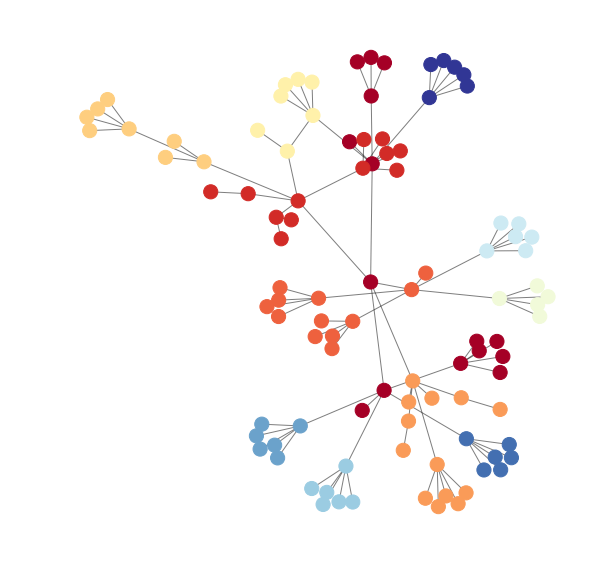

In [11]:
# Reference from Stack-Over-Flow
partition = community.best_partition(G)  # compute communities

pos = nx.spring_layout(G)  # compute graph layout
plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=200, cmap=plt.cm.RdYlBu, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show(G)